In [3]:
pip install lecroyparser

Note: you may need to restart the kernel to use updated packages.


In [84]:
pip install tables

     |################################| 6.0 MB 2.9 MB/s            
     |################################| 378 kB 31.4 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [276]:
import numpy as np
from matplotlib import pyplot as plt
import os
import lecroyparser

# mount my drive 
#from google.colab import drive
#drive.mount('/content/drive')
path='/jupyter-workspace/cloud-storage/cygno-data/WC/'

C1--WC--02802.trc
Le Croy Scope Data
Path: None - from bytes data
Endianness: <
Instrument: LECROYWaveRunner
Instrument Number: 20543
Template Name: LECROY_2_3
Channel: Channel 1
WaveArrayCount: 2002
Vertical Coupling: DC1M
Bandwidth Limit: off
Record Type: single_sweep
Processing: No Processing
TimeBase: 10 ns/div
TriggerTime: 2023-05-08 15:38:11.36

2.59448e-06 10 ns/div -9.944604023496574e-08 0.076


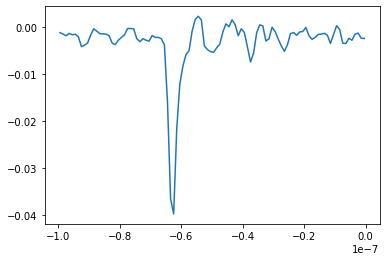

 int: 2.08e-10, min: -0.040, mean out of time: -0.002


In [17]:
def wave_s(path, filename, usamle, verbose=False):
    import numpy as np

    if verbose: 
        print(filename)
        
    f = open(path+filename, 'rb')
    data = lecroyparser.ScopeData(data = f.read(), sparse = usamle)
    plt.plot(data.x, data.y)

    if verbose: 
        print (data)
        print(data.verticalGain, data.timeBase, data.horizOffset, data.verticalOffset)
    f.close()
    plt.show()
    print(" int: {:.2e}, min: {:.3f}, mean out of time: {:.3f}".format(np.trapz(data.x, data.y),  
                                                        np.min(data.y), 
                                                        np.mean(data.y[data.x<-0.7e-7])))

wave_s(path, filename='C1--WC--02802.trc', usamle = 100, verbose=True)

In [211]:
path='/jupyter-workspace/cloud-storage/cygno-data/WC/'
files_all = os.listdir(path)

In [283]:
def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def wave(path, files, usamle, th = -0.005, doplot=False, verbose=False):
    import numpy as np
    x_cut_min = -0.85e-7
    x_cut_max = -0.50e-7
    under_th = []
    min_w = []
    int_w = []
    min_pos_w = []
    for i, filename in enumerate(files):
        f = open(path+filename, 'rb')
        data = lecroyparser.ScopeData(data = f.read(), sparse = usamle)
        data_offset = np.mean(data.y[data.x<x_cut_min])
        data_offsigma = np.std(data.y[data.x<x_cut_min])
        if verbose: 
            print(i, path, filename)
            print(data_offset, data_offsigma)
        #print(data_offset, data_offsigma)
        y = data.y-data_offset
        min_w.append(np.min(y))
        int_w.append(np.trapz(y))

        #min_pos_w.append(data.x[np.where(data.y == data.y.min())][0])
        under_th.append(filename)
        if doplot:
            plt.plot(data.x, y)
        if min(y)<th:      
            min_pos_w.append(data.x[np.where(y < th)][0])
        else:
            min_pos_w.append(-1)

            
        if verbose: print (data)
        f.close()
    if doplot:
        plt.ylim(-0.030, 0.010)
        plt.axhline(th)
        plt.axvline(x_cut_min)
        plt.show()

    return np.array(under_th), np.array(min_w), np.array(int_w), np.array(min_pos_w)


def histGaus(var, bins, ax, color='b', xrange=False, alpha=1, label=''):
    from sklearn.metrics import r2_score
    from scipy.stats import chisquare
    import scipy.stats as stats
    from scipy.optimize import curve_fit
    import numpy as np
    var = np.array(var)
    if xrange:
        ax.hist(var, bins=bins, label=label, color=color, range=(xrange[0], xrange[1]), alpha=alpha)
        y, bins_edge = np.histogram(var, bins=bins, range=(xrange[0], xrange[1]))
        p0=[y.max(),bins_edge[y.argmax()], np.std(var[var>xrange[0]])]
        #print(p0)
    else:
        ax.hist(var, bins=bins, label=label, color=color)
        y, bins_edge = np.histogram(var, bins=bins)
        p0=[y.max(),bins_edge[y.argmax()], np.std(var)]
    x = np.linspace(bins_edge[0], bins_edge[-1], bins)
    popt, pcov = curve_fit(Gauss3, x, y, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    r2=r2_score(y, Gauss3(x, *popt))
    x = np.linspace(bins_edge[0], bins_edge[-1], 100)
    sstat='a = {0:.2e} +/- {1:.2e}\nb = {2:.2e} +/- {3:.2e} \
    \nc = {4:.2e} +/- {5:.2e}\n$R^2$ = {6:.4f}'.format(popt[0], perr[0], popt[1], perr[1], 
                                                popt[2], perr[2], r2)
    ax.plot(x,Gauss3(x, *popt), color+'--', label=sstat)
    return ax

def outdata(min_w, int_w, min_pos_w):
    fig, ax = plt.subplots(1,3, figsize=(12, 5))
    ax[0].hist(min_w, bins=100, color='r')
    ax[0].set_title("min value")
    ax[0].set_xlim(-0.1, 0)
    ax[0].set_yscale('log')
    ax[1].hist(int_w, bins=100, color='gray')
    ax[1].set_title("charge")
    ax[1].set_xlim(-2, 0)
    ax[1].set_yscale('log')
    ax[2]=histGaus(min_pos_w, bins=50, ax=ax[2], color='b', xrange=[-8e-8, -5e-8], alpha=1, label='')
    ax[2].set_title("time th")
    plt.legend()
    plt.show()
    return


def outdata2(C1, C2, th1, th2, verbose=False):
    C1 = np.array(C1)
    C2 = np.array(C2)
    print (len(C1), len(C2))
    fig, ax = plt.subplots(1,2, figsize=(8, 5))
    cond=(C1<th1) & (C2<th2)
    #print(cond)
    ax[0].plot(C1[cond], C2[cond], 'k.')
    ax[0].set_title("C1 vs C2 (C1<{:.3f})".format(th))
    ax[0].set_xlim(-2, 0)
    ax[0].set_ylim(-2, 0)

    ax[1].hist(C1[cond]/C2[cond], bins=50, color='gray', label="{:.2f}".format(np.mean(C1[cond]/C2[cond])))
    #print(C1[cond], C2[cond], C1[cond]/C2[cond])
    ax[1].set_title("C1/C2 (C1<{:.3f} C2<{:.3f})".format(th1, th2))
    ax[1].set_xlim(0, 20)
    ax[1].set_yscale("log")
    ax[1].legend()
    plt.show()
    return



0 /jupyter-workspace/cloud-storage/cygno-data/WC/ C2--WC--middle--flter--00011.trc
-0.0013902953 0.0003079126
Le Croy Scope Data
Path: None - from bytes data
Endianness: <
Instrument: LECROYWaveRunner
Instrument Number: 20543
Template Name: LECROY_2_3
Channel: Channel 2
WaveArrayCount: 2002
Vertical Coupling: DC1M
Bandwidth Limit: on
Record Type: single_sweep
Processing: No Processing
TimeBase: 10 ns/div
TriggerTime: 2023-05-11 14:10:53.99



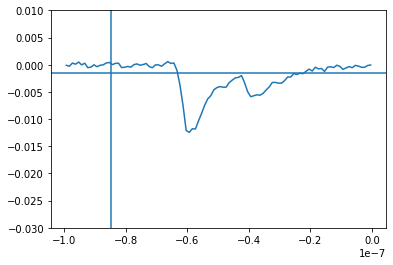

(array(['C2--WC--middle--flter--00011.trc'], dtype='<U32'),
 array([-0.01243569], dtype=float32),
 array([-0.21842462], dtype=float32),
 array([-6.23915069e-08]))

In [167]:
# from scipy import signal
# usamle = 100
# data = lecroyparser.ScopeData(path+'C1--WC--middle--flter--00005.trc')
# plt.plot(data.x, data.y)
# data_rs = signal.resample(data.y, usamle, data.x)
# plt.plot(data_rs[1], data_rs[0])
# plt.ylim(-0.030, 0.010)
# #plt.xlim(-8e-8, -5e-8)
# plt.show()
wave(path, ["C2--WC--middle--flter--00011.trc"], usamle, th = -0.0015, doplot=True, verbose=True)

In [21]:
print("total files", len(files_all))

files3 = [f for f in files_all if 'C3' in f]
files2 = [f for f in files_all if 'C2' in f]
files1 = [f for f in files_all if 'C1' in f]
files0 = [f for f in files_all if 'C0' in f]
print ("C0", len(files0))
print ("C1", len(files1))
print ("C2", len(files2))
print ("C3", len(files3))
    

total files 94189
C0 0
C1 28377
C2 28378
C3 28384


In [22]:

filest1 = [f for f in files_all if 'trigger1' in f]
filest2 = [f for f in files_all if 'trigger2' in f]
filesf = [f for f in files_all if 'flter' in f]
filesm = [f for f in files_all if 'middle' in f]
print(len(filest1), len(filest2), len(filesf), len(filesm))

21889 6708 39097 12848


In [23]:
files_trL = [f for f in filesf if 'trigger1' in f]
files_trC = [f for f in filesf if 'middle' in f]
files_trR = [f for f in filesf if 'trigger2' in f]
print(len(files_trL), len(files_trC), len(files_trR))

17412 8568 6708


In [25]:
sample=1000
C1_trL = [f for f in files_trL if 'C1' in f][:sample]
C2_trL = [f for f in files_trL if 'C2' in f][:sample]
C3_trL = [f for f in files_trL if 'C3' in f][:sample]
print(len(C1_trL), len(C2_trL), len(C3_trL))
C1_trR = [f for f in files_trR if 'C1' in f][:sample]
C2_trR = [f for f in files_trR if 'C2' in f][:sample]
C3_trR = [f for f in files_trR if 'C3' in f][:sample]
print(len(C1_trR), len(C2_trR), len(C3_trR))
C1_trC = [f for f in files_trC if 'C1' in f][:sample]
C2_trC = [f for f in files_trC if 'C2' in f][:sample]
C3_trC = [f for f in files_trC if 'C3' in f][:sample]
print(len(C1_trC), len(C2_trC), len(C3_trC))

1000 1000 1000
1000 1000 1000
1000 1000 1000


In [ ]:
path='/jupyter-workspace/cloud-storage/cygno-data/WC/'
th = -0.005
# under_th, min_w, int_w, min_pos_w = wave(path, C3_trL, usamle, th = th)
# print(len(under_th))
# fig, ax = plt.subplots(1,3, figsize=(9, 3))
# ax[0].hist(min_w, bins=len(min_w))
# ax[1].hist(int_w, bins=len(int_w))
# ax[2].hist(min_pos_w, bins=len(min_pos_w))
# plt.show()

under_th, min_w, int_w, min_pos_w = wave(path, C2_trL, usamle, th = th)
outdata(under_th, min_w, int_w, min_pos_w)
c2 = int_w
under_th, min_w, int_w, min_pos_w = wave(path, C1_trL, usamle, th = th)
outdata(min_w, int_w, min_pos_w)
c1 = int_w
outdata2(c1, c2)

under_th, min_w, int_w, min_pos_w = wave(path, C2_trC, usamle, th = th)
outdata(min_w, int_w, min_pos_w)
c2 = int_w
under_th, min_w, int_w, min_pos_w = wave(path, C1_trC, usamle, th = th)
outdata(min_w, int_w, min_pos_w)
c1 = int_w
outdata2(c1, c2)

under_th, min_w, int_w, min_pos_w = wave(path, C2_trR, usamle, th = th)
outdata(min_w, int_w, min_pos_w)
c2 = int_w
under_th, min_w, int_w, min_pos_w = wave(path, C1_trR, usamle, th = th)
outdata(min_w, int_w, min_pos_w)
c1 = int_w
outdata2(c1, c2)

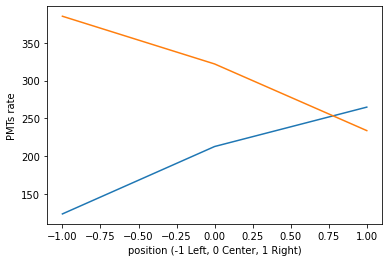

In [27]:
ne = np.array([[124,385],
     [213,322],
     [265,234]])
plt.plot([-1,0,1], ne[:,0])
plt.plot([-1,0,1], ne[:,1])
plt.ylabel("PMTs rate")
plt.xlabel("position (-1 Left, 0 Center, 1 Right)")
plt.show()

In [297]:
path='/jupyter-workspace/cloud-storage/cygno-data/WC/'
files_all = os.listdir(path)
sample = 600
where = 'center--2150'
CFD = [f for f in files_all if 'CFD' in f]
side = [f for f in CFD if where in f]
C1_tr1 = [f for f in side if 'C1' in f][:sample]
C2_tr1 = [f for f in side if 'C2' in f][:sample]
C3_tr1 = [f for f in side if 'C3' in f][:sample]
print(len(C1_tr1), len(C1_tr1), len(C3_tr1))


2 2 6


In [292]:
import pandas as pd
df = pd.DataFrame()
# dt = pd.DataFrame()
th = -0.0015
under_th, min_w, int_w, min_pos_w = wave(path, C1_tr1, usamle, th = th)
df['c1_under_th']=under_th
df['c1_min']=min_w
df['c1_int_w']=int_w
df['c1_min_pos_w']=min_pos_w
under_th, min_w, int_w, min_pos_w = wave(path, C2_tr1, usamle, th = th)
df['c2_under_th']=under_th
df['c2_min']=min_w
df['c2_int_w']=int_w
df['c2_min_pos_w']=min_pos_w

In [294]:
store = pd.HDFStore(where+str(sample)+'.h5')
store['df'] = df
#store['df'] to read

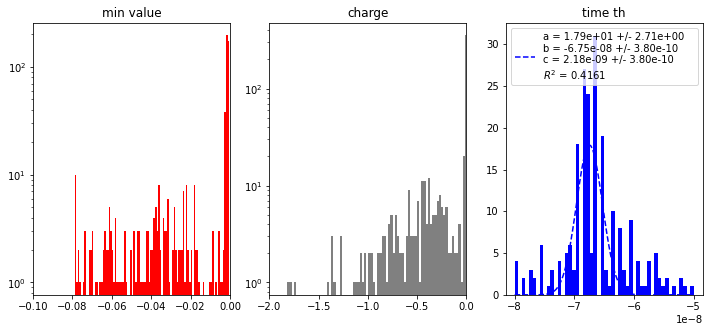

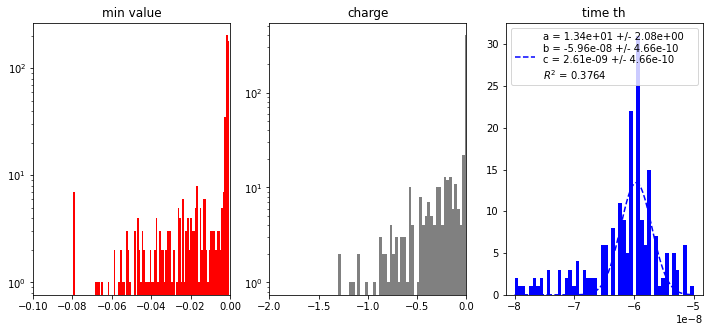

In [295]:

outdata(df['c1_min'][:sample], df['c1_int_w'][:sample], df['c1_min_pos_w'][:sample])
outdata(df['c2_min'][:sample], df['c2_int_w'][:sample], df['c2_min_pos_w'][:sample])


600 600


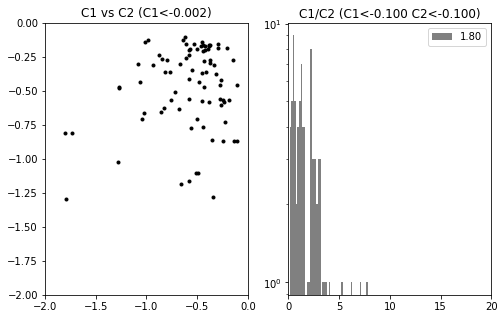

In [296]:
outdata2(df['c1_int_w'][:sample], df['c2_int_w'][:sample], th1= -0.1, th2=-0.1)

In [91]:
store = pd.HDFStore('site1_CFD.h5')
dr = store["df"]

In [27]:
# siamo al centro
# file 610 cambiata soglia C2 a 1900
# 672 HV 1850
# 725 cambiata scala oscilloscopio al centro
# 1080 spostato su C2
# 1430 ci spostiemo su C1
# 2170 rimettiamo al 
# in mezzo butta
# 2337 vicino C2
#files_all = [f for f in files_all if (int(f[8:13]) > 1080 and int(f[8:13]) < 1420) ]
# files_all = [f for f in files_all if (int(f[8:13]) > 725 and int(f[8:13]) < 1070) ]
#files_all = [f for f in files_all if (int(f[8:13]) > 1430 and int(f[8:13]) < 2160) ]
#files_all = [f for f in files_all if (int(f[8:13]) > 2340) ]
# usamle = 100 # -1 read all https://pypi.org/project/lecroyparser/
# files = [f for f in files_all if 'C3' in f]
# under_th_C3 = wave(path, files, usamle, th = th)
# print ("C0", len(under_th_C3))
# files = [f for f in files_all if 'C1' in f]
# under_th_C1 =wave(path, files, usamle, th = th)
# print ("C1", len(under_th_C1))
# files = [f for f in files_all if 'C2' in f]
# under_th_C2 =wave(path, files, usamle, th = th)
# print ("C2", len(under_th_C2))

In [285]:
# def wave_s_d(path, fC1, fC2, verbose=False):
#     import numpy as np
#     x_cut_min = -0.85e-7
#     x_cut_max = -0.50e-7
#     t_C1 = []
#     t_C2 = []
#     f = open(path+fC1, 'rb')
#     data_C1 = lecroyparser.ScopeData(data = f.read(), sparse = usamle)
#     f = open(path+fC2, 'rb')
#     data_C2 = lecroyparser.ScopeData(data = f.read(), sparse = usamle)

#     plt.plot(data_C1.x, data_C1.y, label="C1")
#     plt.plot(data_C1.x, data_C2.y, label="C2")
#     plt.axvline(x_cut_min)
#     plt.axvline(x_cut_max)

#     f.close()
#     plt.legend()
#     plt.ylim(-0.45, 0.05)
#     plt.xlim(-1e-7, 0)
#     plt.show()
#     t0_C1 = data_C1.x[np.where(data_C1.y == data_C1.y.min())][0]
#     t0_C2 = data_C2.x[np.where(data_C2.y == data_C2.y.min())][0]
#     x0_C1 = np.min(data_C1.y[data_C1.x<x_cut_min])
#     x0_C2 = np.min(data_C2.y[data_C2.x>x_cut_min])
#     i0_C1 = np.trapz(data_C1.y[data_C1.x<x_cut_min])
#     i0_C2 = np.trapz(data_C2.y[data_C2.x>x_cut_min])

#     print(" int: {:.2e}, min: {:.3f}, mean out of time: {:.2e} {}".format(np.trapz(data_C1.x[data_C1.x>x_cut_min], 
#                                                                                 data_C1.y[data_C1.x>x_cut_min]),  
#                                                          np.min(data_C1.y[data_C1.x>x_cut_min]), 
#                                                          np.mean(data_C1.y[data_C1.x<x_cut_min]), t0_C1))
#     print(" int: {:.2e}, min: {:.3f}, mean out of time: {:.2e} {}".format(np.trapz(data_C2.x[data_C2.x>x_cut_min], 
#                                                                                 data_C2.y[data_C2.x>x_cut_min]),  
#                                                          np.min(data_C2.y[data_C2.x>x_cut_min]), 
#                                                          np.mean(data_C2.y[data_C2.x<x_cut_min]), t0_C2))
#     return t0_C1, t0_C2, x0_C1, x0_C2, i0_C1, i0_C2
# i = 21
# t_C1 = []
# t_C2 = []
# x_C1 = []
# x_C2 = []
# i_C1 = []
# i_C2 = []
# for i in range(np.min([len(under_th_C2), len(under_th_C1)])):
#     t0_C1, t0_C2, x0_C1, x0_C2, i0_C1, i0_C2 = wave_s_d(path, under_th_C1[i], under_th_C2[i], verbose=True)
#     t_C1.append(t0_C1)
#     t_C2.append(t0_C2)
#     x_C1.append(x0_C1)
#     x_C2.append(x0_C2)
#     i_C1.append(i0_C1)
#     i_C2.append(i0_C2)
